### 1.2  Power spectrum estimation

In [1]:
using Distributions
using FFTW
using DSP
using Plots
using Random

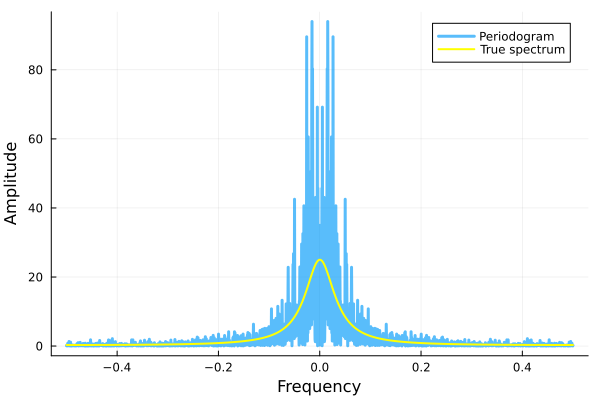

In [2]:
N = 2000
a = -0.8

f = LinRange(-0.5, 0.5, N)

μ, σ = 0.0, 1.0  # Mean and standard deviation of the normal distribution
𝑁 = Normal(μ, σ)
x = rand(𝑁, N)
y = filt([1], [1, a], x)
Yf = fft(y)
Py = 1 / N * abs2.(Yf)
plot(f, fftshift(Py) # fftshift is used to center the zero frequency component
    , alpha=0.65
    , label = "Periodogram"
    , xlabel = "Frequency", ylabel = "Amplitude"
    , legend = :topright
    , linewidth = 3
)

h = [1, a] # Create an impulse response and manually zero-pad to length N
h_padded = vcat(h, zeros(N - length(h)))
H = fft(h_padded) # Take FFT of the zero-padded impulse response
Sy = abs.(1 ./ abs.(H).^2) # Calculate the true spectrum
plot!(f, fftshift(Sy)
    , color="yellow"
    , linewidth = 2
    , label="True spectrum"
)

The provided source code calculates and plots the true power spectrum of a signal. Here's a breakdown of what it does:

1. `N = 2000`: Defines the number of data points in the signal.

2. `a = -0.8`: Specifies a filter coefficient. This coefficient represents a filter with a single pole at `a` when used in the context of signal filtering.

3. `fft([1, a], N)`: Computes the Fast Fourier Transform (FFT) of a filter represented by the coefficients `[1, a]`. This effectively calculates the frequency response of the filter.

4. `abs(1 / abs(...)**2)`: This part of the code computes the power spectrum of the filter. Here's how it works:
   - `abs(...)` calculates the magnitude of each element in the frequency response.
   - `1 / abs(...)**2` takes the reciprocal of the square of the magnitude of each element, effectively calculating the power spectrum.

5. `plt.plot(f, fftshift(Sy), color="yellow", lw=2, label="True spectrum")`: This line plots the true spectrum:
   - `f`: Represents the frequency values corresponding to the FFT result.
   - `fftshift(Sy)`: Rearranges the power spectrum values so that the zero frequency component is in the center of the plot (useful for visualization).
   - `color="yellow"`: Specifies the color of the plotted line.
   - `lw=2`: Sets the line width of the plot.
   - `label="True spectrum"`: Adds a label to the plot for reference.

In summary, this code computes the true power spectrum of a filter specified by the coefficient `a` and plots it against the corresponding frequencies. The power spectrum represents the distribution of signal power across different frequency components, providing insights into the frequency characteristics of the filter.

In [3]:
# Assuming Py is already defined from previous operations
Ry = ifft(Py);

# Create a Hamming window with 200 points
# In Julia, the Hamming window function in the DSP package does not have a 'sym' parameter
# The function by default creates symmetric windows, which is equivalent to 'sym=True' in Python's scipy.signal.hamming
# hh = hamming(200);

In [4]:
using DSP.Windows
using StatsBase

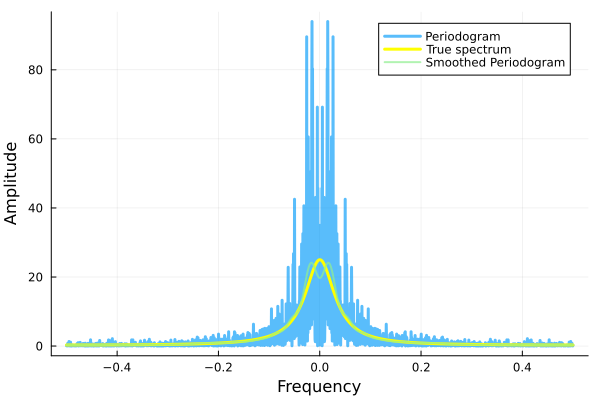

In [5]:
L = 100

# Define the Hann window using DSP.Windows.hanning
h = hanning(L)

# Shift the Hann window using FFTW's fftshift
h = fftshift(h)

z = zeros(N)
z[1:div(L, 2)] .= h[1:div(L, 2)]
z[end:-1:end-div(L, 2)+1] .= h[end:-1:end-div(L, 2)+1]

# Perform FFT on z multiplied by Ry (assuming Ry is defined)
Py_smoothed = abs.(fft(z .* Ry))

plot(f, fftshift(Py) # fftshift is used to center the zero frequency component
    , alpha=0.65
    , label = "Periodogram"
    , xlabel = "Frequency", ylabel = "Amplitude"
    , legend = :topright
    , linewidth = 3
)
plot!(f, fftshift(Sy)
    , color="yellow"
    , linewidth = 3
    , label="True spectrum"
)
plot!(f, fftshift(Py_smoothed)
    , alpha=0.7
    , color="lightgreen"
    , linewidth = 2
    , label="Smoothed Periodogram"
)

In [6]:
function averaged_perio(y, M)
    N = length(y)
    L = Int(round(N / M))
    Py_averaged = zeros(Complex{Float64}, N)
        
    for m in 0:M-1
        low = (m * L + 1)
        up = (m + 1) * L
        y_trunk = y[low:up]
        y_padded = vcat(y_trunk, zeros(N - length(y_trunk)))
        y_f = fft(y_padded)# ; @show low, up, length(y_trunk), N
        Py_averaged .+= (1 / L) .* abs2.(y_f)
    end
    
    return Py_averaged / M
end

averaged_perio (generic function with 1 method)

In [7]:
# Assuming y is defined elsewhere
Py_averaged = averaged_perio(y, 20);

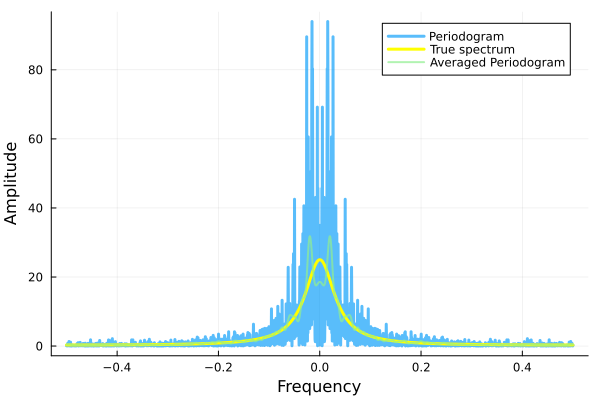

In [8]:
plot(f, fftshift(Py) # fftshift is used to center the zero frequency component
    , alpha=0.65
    , label = "Periodogram"
    , xlabel = "Frequency", ylabel = "Amplitude"
    , legend = :topright
    , linewidth = 3
)
plot!(f, fftshift(Sy)
    , color="yellow"
    , linewidth = 3
    , label="True spectrum"
)
plot!(f, fftshift(abs.(Py_averaged))
    , alpha=0.7
    , color="lightgreen"
    , linewidth = 2
    , label="Averaged Periodogram"
)

### 2.1  Matched filter

In [9]:
using Plots; gr()
using DSP

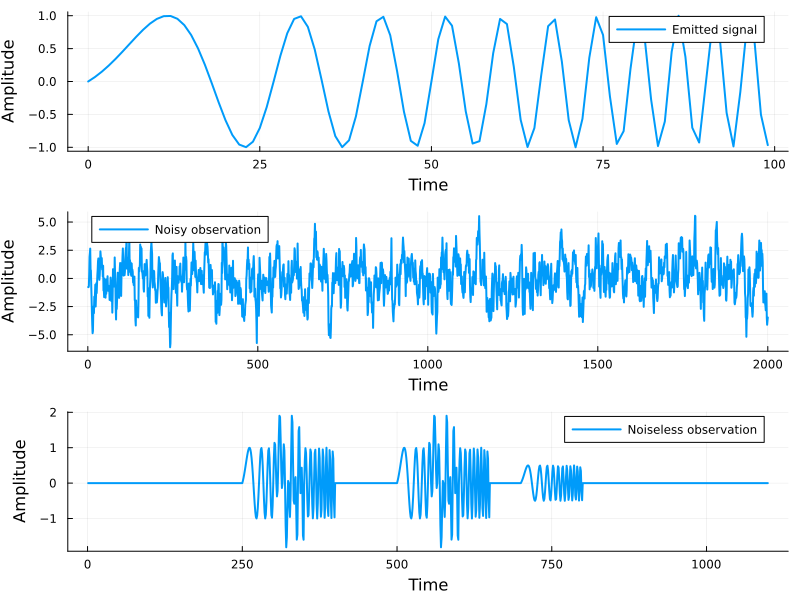

In [10]:
N = 1000

# Interface detection by cross-correlation
t = 0:99
A = 0.5
# s = 1.0 .* sin.(2 * π .* 0.01 .* (1.0 .+ 0.1 .* t) .* t)  # Emitted signal
s = sin.(2 * π .* 0.01 .* (1.0 .+ 0.1 .* t) .* t)  # Emitted signal
pl1 = plot(t, s, label="Emitted signal", xlabel="Time", ylabel="Amplitude", legend=:topright)

# List of interfaces
pos = [250, 300, 500, 550, 700]
amp = [1.0, 1.0, 1.0, 1.0, 0.5]
g = zeros(N)
g[pos] .= amp

# Add noise
A = 0.1
z = y .+ A .* randn(size(y))
pl2 = plot(z, label="Noisy observation", xlabel="Time", ylabel="Amplitude", legend=true)

# Convolution to generate the noiseless observation
y = conv(s, g)
pl3 = plot(y, label="Noiseless observation", xlabel="Time", ylabel="Amplitude", legend=true)

plot(pl1,pl2,pl3
    , layout = (3,1)
    , linewidth = 2
    , size = (800,600)
)

In [11]:
function zeropad(v, N)
    a = zeros(eltype(v), N)
    a[1:length(v)] .= v
    return a
end

zeropad (generic function with 1 method)

In [12]:
# Padding is not needed since DSP.xcorr does the padding by default, padmode = :none
sp = zeropad(s, length(z)); 

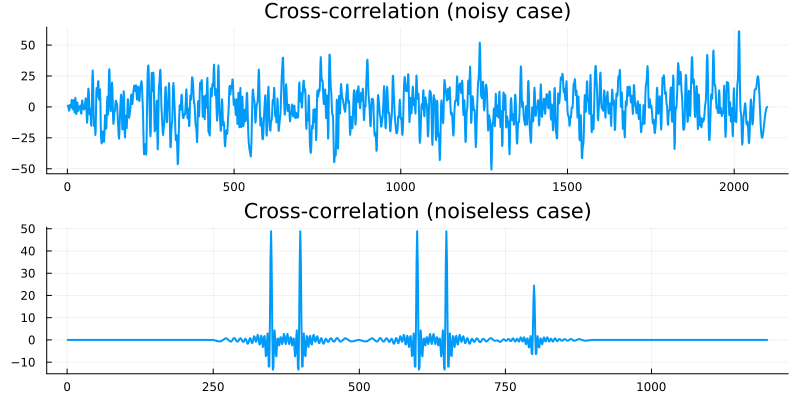

In [13]:
# Cross-correlation (noisy case)
Rzs = xcorr(z, s, padmode = :none)
pl1 = plot(Rzs, title="Cross-correlation (noisy case)")
# Cross-correlation (noiseless case)
Rys = xcorr(y, s, padmode = :none)
pl2 = plot(Rys, title="Cross-correlation (noiseless case)")
plot(pl1,pl2
    , layout = (2,1)
    , linewidth = 2
    , legend = :none
    , size = (800,400)
)

In [14]:
# Calculate lag values
L = max(length(z), length(s))
lags = -(L - 1) : (L - 1); @show lags

# If the cross-correlation result is shorter than the full range of lags (which happens with padmode = :none),
# adjust the lags array to match the length of Rzs.
# This is needed because with :none, the actual length of Rzs might vary.
actual_length = length(Rzs)
half_length_difference = (length(lags) - actual_length) ÷ 2
adjusted_lags = lags[(half_length_difference + 1):(end - half_length_difference)]


lags = -1999:1999


-1049:1049

In [15]:
using StatsBase

alpha = 0.999
loc = 0
scale = 1

interv = quantile(Normal(loc, scale), [(1 - alpha) / 2, 1 - (1 - alpha) / 2])
println(interv)


[-3.290526731491899, 3.290526731491931]


In [16]:
LR = length(Rzs)
Rzs_th = zeros(LR)
intervs = interv * std(Rzs[500:end])  # Adjusted for Julia indexing

Rzs_th .= [
    (Rzs[u] < intervs[1] || Rzs[u] > intervs[2]) ? Rzs[u] : 0
    for u in 1:LR
]

# fig, ax = subplots(1, 1, figsize=(8, 3))


# println("The position of interfaces are at", findall(x -> x != 0, Rzs_th) .+ lags[1])
println("The position of interfaces are at", findall(x -> x != 0, Rzs_th) .+ adjusted_lags[1])

intervs

The position of interfaces are at[188, 223, 965, 966]


2-element Vector{Float64}:
 -50.389735729839956
  50.389735729840446

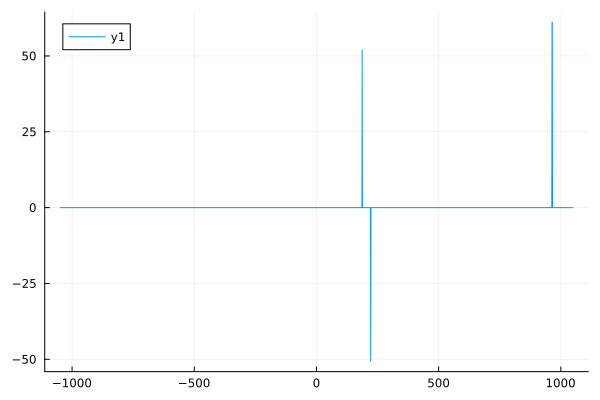

In [17]:
plot(adjusted_lags,Rzs_th)

## 2.2  Wiener filtering

#### 2.2.2  Illustrative experiment

In [18]:
using Distributions  # For Bernoulli distribution
using DSP  # For signal processing functions
using FFTW  # For FFT and IFFT
using Plots  # For plotting

In [19]:
N = 2000
a = -0.97
L = 50

# Create Bernoulli distributed signal spos
spos = rand(Bernoulli(0.6), div(N, L))

# Repeat each element of spos L times
sₛₚₒₛ = repeat(spos, inner=L)

# Dirac impulse
d = zeros(N)
d[1] = 1  # Indexing starts from 1 in Julia

# Filter design and convolution (lfilter equivalent in Julia is filt)
b = [1, 0.5, 0.95]
a_coeffs = [1, a]
h = filt(b, a_coeffs, d);

In [20]:
# FFT of h and s, and their product
H = fft(h)
S = fft(sₛₚₒₛ)
X = S .* H

# Inverse FFT to get the real part of the signal
x = real(ifft(X));

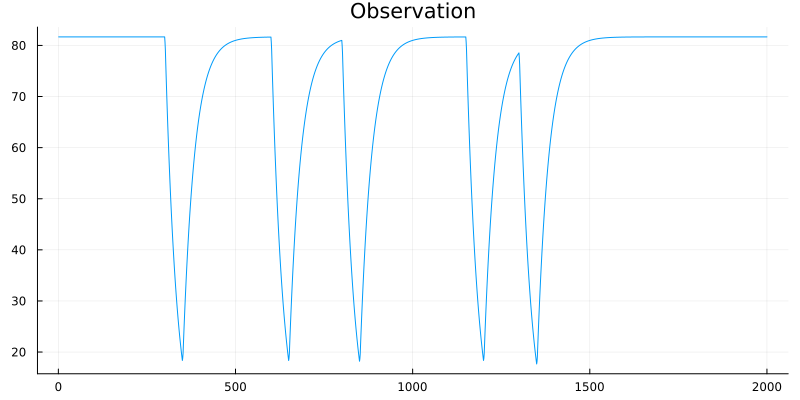

In [21]:
# Plotting the observation
plot(x, title="Observation", legend = :none, size = (800,400))

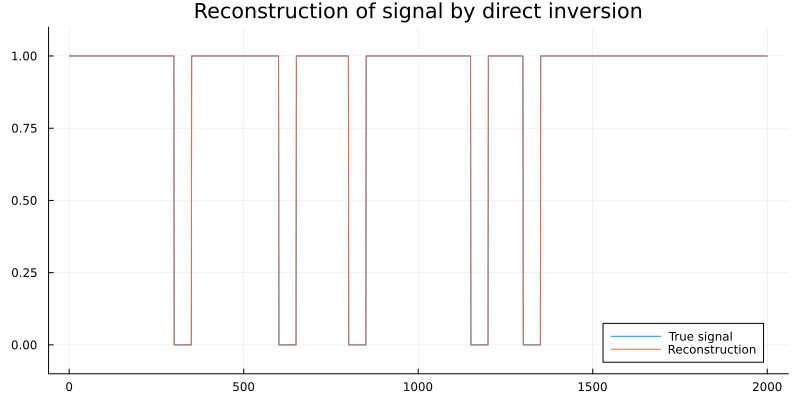

In [22]:
# Reconstruction
x_rec = real(ifft(X ./ H))
plot(sₛₚₒₛ, label="True signal")
plot!(x_rec, label="Reconstruction", title="Reconstruction of signal by direct inversion"
    , ylim=(-0.1, 1.1), legend=:bottomright
    , size = (800,400)
)


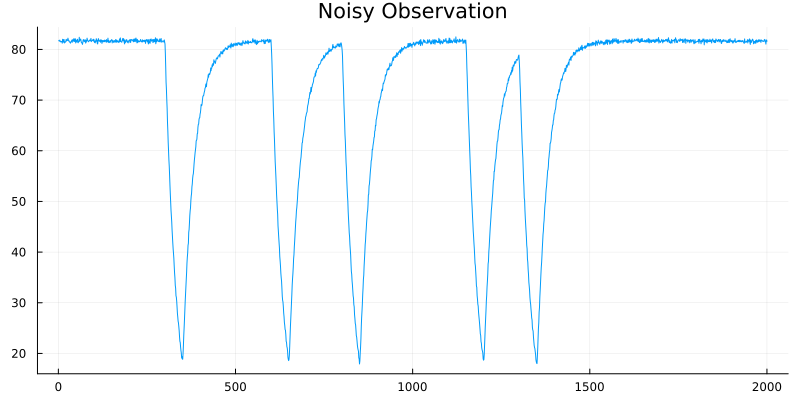

In [23]:
# Generate noisy observation
z = x + 0.25 * rand(Normal(0, 1), N)
Z = fft(z)

# Plot the noisy observation
plot(z, title="Noisy Observation", legend = :none, size = (800,400))

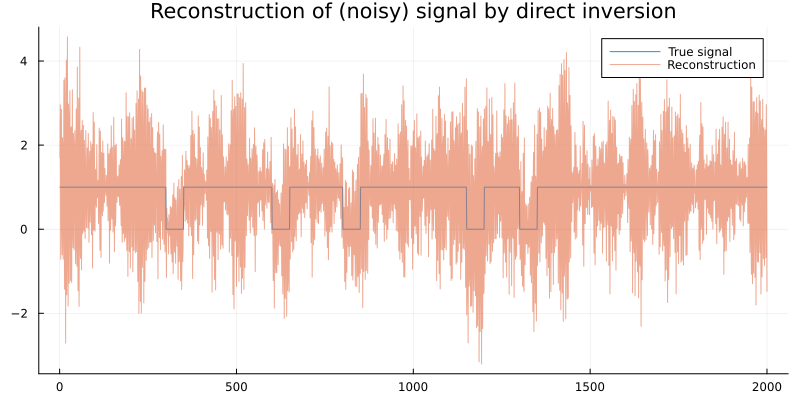

In [24]:
# Reconstruction from the noisy signal
x_rec = real(ifft(Z ./ H))

# Plot the true signal and its reconstruction
plot(sₛₚₒₛ, label="True signal", legend=:topright, size = (800,400))
plot!(x_rec, alpha=0.6
    , label="Reconstruction", title="Reconstruction of (noisy) signal by direct inversion"
)

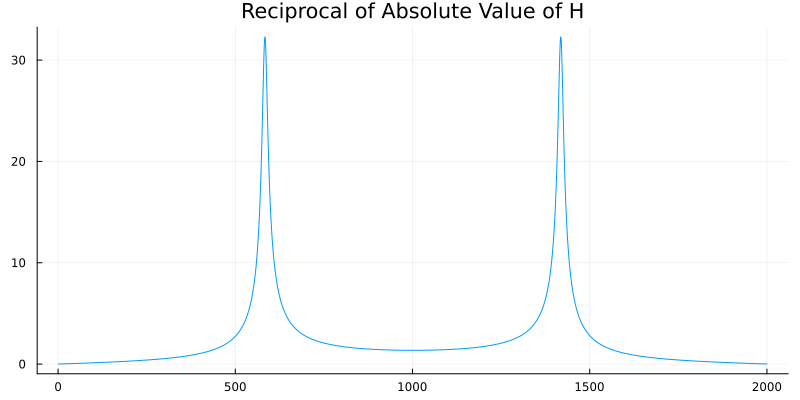

In [25]:
plot(1 ./ abs.(H), title="Reciprocal of Absolute Value of H", legend = :none, size = (800,400))

In [26]:
ϕ(ω) = 2π .+ rand(ω)

ϕ (generic function with 1 method)

Simulate a signal $s_3(n)=exp^{(−at)}sin(2πf_0t+ϕ(ω))$.

In [27]:
a = 1e-3
𝑓₀ = 1e-3
ω = 1;

In [28]:
s₃(t) = exp.(-a * t) .* sin.(2π * 𝑓₀ * t .+ ϕ(ω));

In [29]:
A = 0.2
N = 5000
t = 0:N-1  # Julia arrays are 1-based, so adjust accordingly

0:4999

In [30]:
w = A * rand(Normal(0, 1), N);

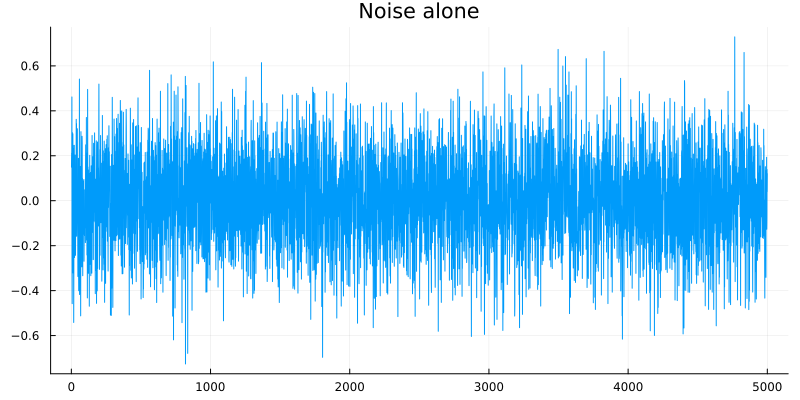

In [31]:
# Plotting noise alone
plot(w, title = "Noise alone", label = false, size = (800,400))
# savefig("noise_alone.png")  # Save the figure

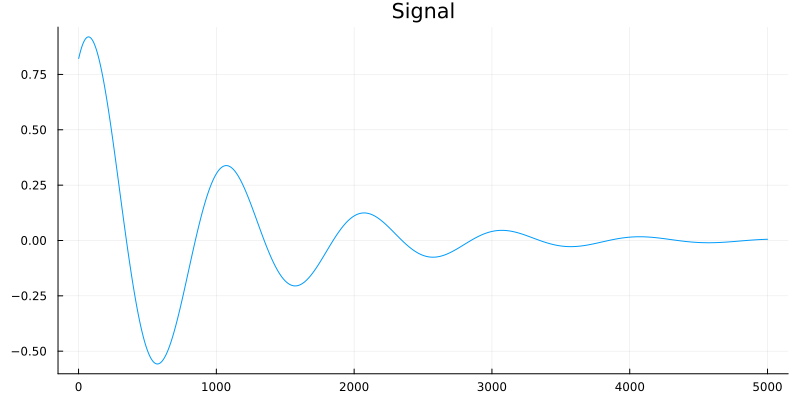

In [32]:
# Signal
plot(s₃(t), title = "Signal", label = false, size = (800,400))
# savefig("signal.png")  # Save the figure

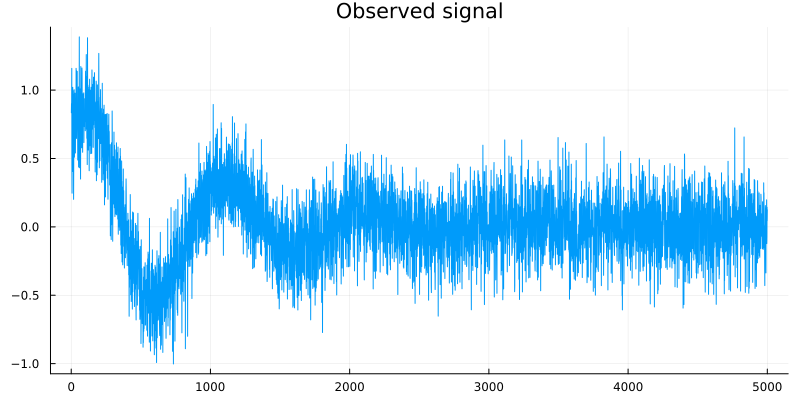

In [33]:
# Observed signal
x = s₃(t) .+ w
plot(x, title = "Observed signal", label = false, size = (800,400))
# savefig("observed_signal.png")  # Save the figure


size(s₃(t)) = (5000,)


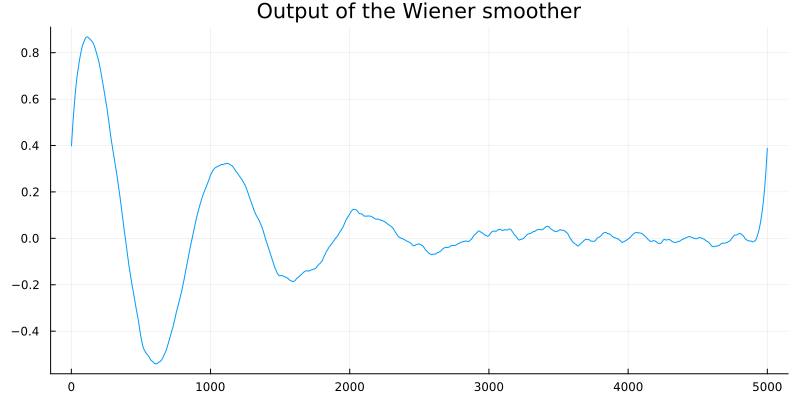

In [34]:
# Power spectral density of the signal
𝑆ₛₛ = 1 ./ N * abs.(fft(s₃(t))).^2; @show size(s₃(t))

# Power spectral density of the noise
𝑆ᵥᵥ = A^2 * ones(N)

# Wiener filter
𝐻 = 𝑆ₛₛ ./ (𝑆ₛₛ .+ 𝑆ᵥᵥ)

# Apply the Wiener filter and perform inverse FFT
xx = real(ifft(𝐻 .* fft(x)))

# Plot the output of the Wiener smoother
plot(xx, title = "Output of the Wiener smoother", label = false, size = (800,400))


# References
- [ ] [Matched Filter](https://perso.esiee.fr/~bercherj/Lectures_SignalProcessing/Lecture3_RandomSignals.html#Matched-filter)

$ s_3(n) = e^{-at} \sin(2\pi f_0 t + \phi(\omega)) $ describes a time-domain signal $s_3(n)$ that combines exponential decay with a sinusoidal component, where the sinusoid's phase is modified by a function of frequency $\omega$. Let's break down the components of this expression:

- $exp^{(−at)}$ represents an exponential decay factor, where $a$ is a positive constant that determines the rate of decay over time $t$.
- $sin(2πf_0t+ϕ(ω))$ is the sinusoidal component, where:
  - $2πf_0t$ indicates the sinusoid's frequency, with $f_0$ being the base frequency of the sinusoid.
  - $ϕ(ω)$ is a phase term that is a function of frequency $\omega$, adding an additional frequency-dependent phase shift to the sinusoid.

The entire expression, therefore, describes a signal that starts off strong and decays exponentially over time, while oscillating sinusoidally with a frequency-dependent phase shift.

In a more general mathematical notation, the signal could be expressed as:

$ s_3(t) = e^{-at} \sin(2\pi f_0 t + \phi(\omega)) $

This kind of signal could be used in various applications, such as in communications for signal modulation, in physics for wave phenomena studies, or in engineering for system response analysis. The frequency-dependent phase shift $\phi(\omega)$ could be particularly useful in applications requiring phase modulation or in systems analysis where phase response is of interest.